<a href="https://colab.research.google.com/github/ijaz-lab/Data-Science-for-Beginner/blob/main/A3_WasteSegregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waste Segregation

## Introduction
This project focuses on classifying waste into two categories: 'Organic' and 'Recyclable' using a Convolutional Neural Network (CNN). Waste segregation is essential for sustainable waste management practices and can significantly contribute to environmental protection.

### Objective
The goal of this analysis is to:
1. Train a CNN model to classify images of waste into categories.
2. Analyze the effect of data augmentation on model performance.
3. Provide insights into model effectiveness and suggest future improvements.

The dataset, sourced from Kaggle, contains images of different types of waste. We use data augmentation techniques to improve the robustness and accuracy of the model.


## Step 1: Importing libraries and check if CUDA is available

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

#### CUDA: Parallel Computing

CUDA (Compute Unified Device Architecture) is a parallel computing platform and programming model developed by [`NVIDIA`](https://docs.nvidia.com/cuda/doc/index.html) that allows developers to leverage the power of NVIDIA GPUs for general-purpose computing. By using CUDA, programmers can execute complex calculations across thousands of GPU cores, significantly accelerating applications in fields like deep learning, scientific computing, and image processing.

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Step 2: Data Augmentation
Data augmentation involves techniques such as cropping, resizing, and flipping image data to achieve more accurate results. In PyTorch, this can be accomplished using transformations.

Normalization brings the data into a specific range and reduces skewness, which helps the model learn more effectively and efficiently. In PyTorch, normalization is performed using transforms.Normalize, where you provide two tuples: one for the mean values of the three RGB channels and another for their standard deviations.

Data augmentation is primarily applied to the training dataset to improve accuracy during training, which can lead to better accuracy on test data. It also increases the number of training images, allowing for multiple augmentations to be applied to training samples.

In deep learning, often the training set is split into train samples and validation samples to cross check accuracies. This is done using SubsetRandomSampler.

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

Loading the directories and training, testing data.

## Step 3: Load the Dataset   
###Waste Segregation Kaggle
/https://www.kaggle.com/datasets/dishantzaveri/wastesegregation)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dishantzaveri/wastesegregation")

print("Path to dataset files:", path)



100%|██████████| 4.04G/4.04G [03:52<00:00, 18.6MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/dishantzaveri/wastesegregation/versions/2


### Step 4: Data Preprocessing
a. Loading the Dataset


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define paths based on the location of the dataset
base_path = "/root/.cache/kagglehub/datasets/dishantzaveri/wastesegregation/versions/2"
train_dir = os.path.join(base_path, "train")  # Adjust as per the actual folder structure
val_dir = os.path.join(base_path, "val")      # Adjust as per the actual folder structure

# Check the dataset folders to verify
print("Training Directory:", train_dir)
print("Validation Directory:", val_dir)


Training Directory: /root/.cache/kagglehub/datasets/dishantzaveri/wastesegregation/versions/2/train
Validation Directory: /root/.cache/kagglehub/datasets/dishantzaveri/wastesegregation/versions/2/val


#### b. Create ImageDataGenerator Instances for Augmentation
Define training and validation generators. The training generator will augment the data, while the validation generator will only rescale the images.

In [ ]:
import os

# List the contents of the base dataset directory
print("Contents of the base dataset directory:")
print(os.listdir(base_path))


Contents of the base dataset directory:
['dataset-original', 'archive (2)', 'archive (3)']


In [ ]:
# Check the contents of 'dataset-original' to determine its structure
dataset_original_path = os.path.join(base_path, "dataset-original")
print("Contents of the dataset-original directory:")
print(os.listdir(dataset_original_path))


Contents of the dataset-original directory:
['dataset-original']


In [ ]:
# Update the path to check inside the nested 'dataset-original' folder
nested_dataset_path = os.path.join(dataset_original_path, "dataset-original")
print("Contents of the nested dataset-original directory:")
print(os.listdir(nested_dataset_path))


Contents of the nested dataset-original directory:
['metal', 'glass', 'paper', 'plastic', 'cardboard', 'trash']


### Step 5: Splitting the Dataset into training and validation sets.
##### a. This script will iterate through each of the six classes and split the data into training and validation sets.

In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Define paths to the original folders for each category
categories = ['metal', 'glass', 'paper', 'plastic', 'cardboard', 'trash']
for category in categories:
    original_path = os.path.join(nested_dataset_path, category)
    train_category_path = os.path.join(base_path, "train", category)
    val_category_path = os.path.join(base_path, "val", category)

    # Create directories if they don't exist
    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(val_category_path, exist_ok=True)

    # Get all file names from the original folder
    category_files = os.listdir(original_path)

    # Split files into training and validation sets (e.g., 80% train, 20% validation)
    train_files, val_files = train_test_split(category_files, test_size=0.2, random_state=42)

    # Move files to the appropriate train/validation folders
    for file in train_files:
        shutil.move(os.path.join(original_path, file), train_category_path)

    for file in val_files:
        shutil.move(os.path.join(original_path, file), val_category_path)

print("Dataset has been successfully split into training and validation sets.")


Dataset has been successfully split into training and validation sets.


#### b. Define Dataset Paths and Set Up Generators
Use ImageDataGenerator for data augmentation and load the images from the newly created training and validation directories.

In [ ]:
# Define dataset paths
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")

# Set up ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Create training and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Resize all images to 128x128 pixels
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 2019 images belonging to 8 classes.
Found 508 images belonging to 8 classes.


#### c. Display Some Augmented Images
Display a few examples of augmented images from the training dataset.

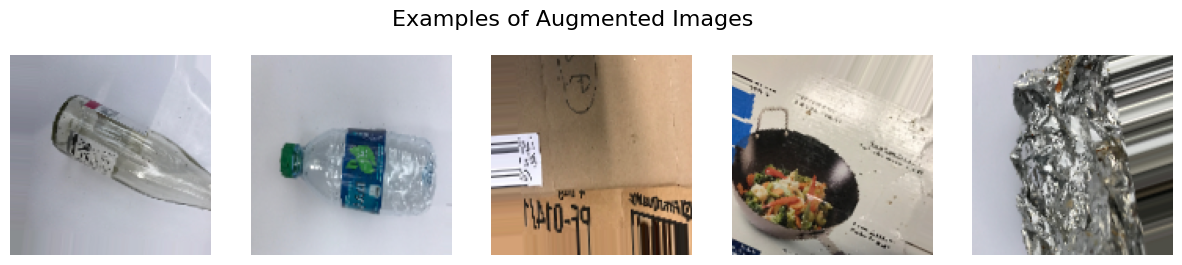

In [ ]:
# Display some augmented images from the training set
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, batch in enumerate(train_generator):
    for j in range(5):
        ax[j].imshow(batch[0][j])
        ax[j].axis('off')
    break
plt.suptitle('Examples of Augmented Images', fontsize=16)
plt.show()


### Step 6: Model Building and Compilation
####a. Define the CNN Model
Build a CNN with batch normalization and dropout to improve generalization and reduce overfitting.

In [ ]:
# Update the output layer to match the number of classes
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Change to 8 to match the number of classes found by the generator
])

# Compile the updated model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the updated model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,518,984 (24.87 MB)

 Trainable params: 6,518,536 (24.87 MB)

 Non-trainable params: 448 (1.75 KB)

### Step 7: Model Training and Evaluation
### a. Train the Model
Train the CNN model on the training data and validate it using the validation data.

In [ ]:
# Check the class indices to make sure all classes are recognized correctly
print("Class indices:", train_generator.class_indices)


Class indices: {'cardboard': 0, 'glass': 1, 'metal': 2, 'organic': 3, 'paper': 4, 'plastic': 5, 'recyclable': 6, 'trash': 7}


In [ ]:
import tensorflow as tf

# Define paths for training and validation directories
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")

# Set batch size and target image size
batch_size = 32
img_size = (128, 128)

# Create training dataset from directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Create validation dataset from directory
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Repeat the datasets indefinitely for training
train_dataset = train_dataset.repeat()
val_dataset = val_dataset.repeat()

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_dataset,
    validation_steps=validation_steps
)



Found 2019 files belonging to 8 classes.
Found 508 files belonging to 8 classes.
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 0.4525 - loss: 1.5363 - val_accuracy: 0.2521 - val_loss: 10.1421
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.5064 - loss: 1.3094 - val_accuracy: 0.3445 - val_loss: 4.3058
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 265ms/step - accuracy: 0.5442 - loss: 1.1752 - val_accuracy: 0.3088 - val_loss: 3.9346
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - accuracy: 0.5743 - loss: 1.1237 - val_accuracy: 0.5735 - val_loss: 1.2267
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.5983 - loss: 1.0799 - val_accuracy: 0.5714 - val_loss: 1.1402
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.6125 - loss: 1.0669 - val_accuracy: 0.5546 - val_loss: 1.2761
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.6818 - loss: 0.8778 - val_accuracy: 0.6050 - val_loss: 1.1465
Epoch 8/10
63/6

### b. Plot Training and Validation Metrics
Visualize training and validation accuracy and loss to understand model performance over epochs

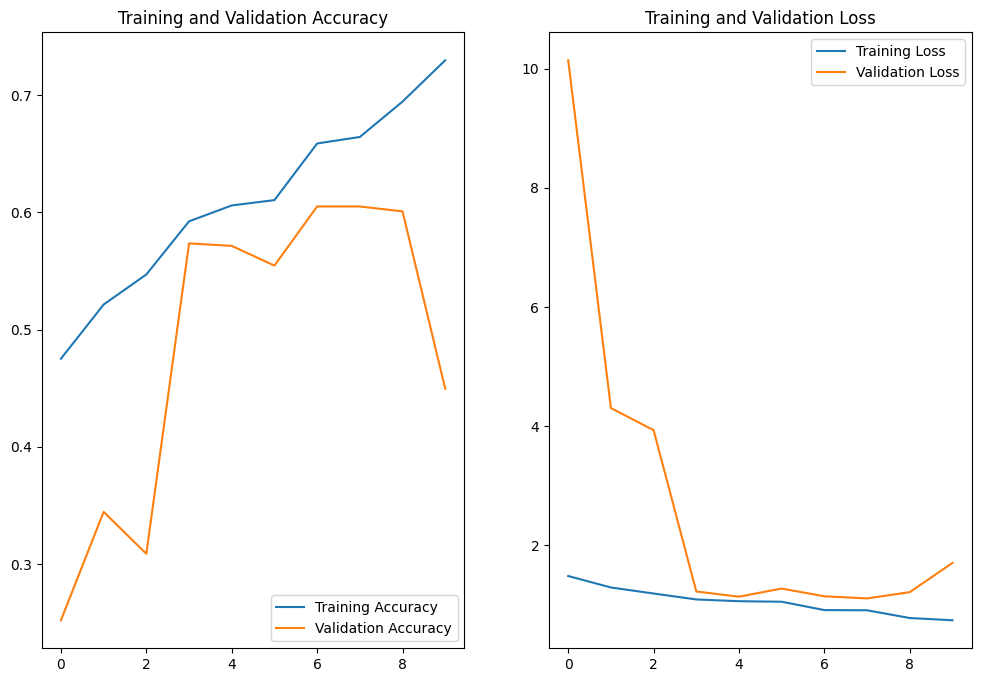

In [ ]:
# Plotting training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### c. Model Evaluation with Confusion Matrix and Classification Report
Evaluate model performance using a confusion matrix and classification report.

16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step


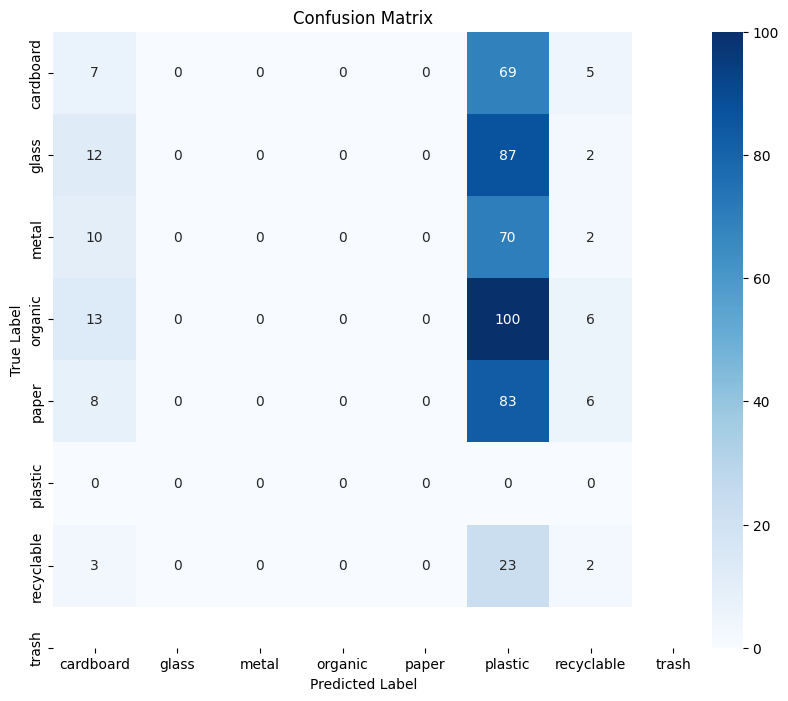

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Predicting validation data
val_generator.reset()
Y_pred = model.predict(val_generator, len(val_generator))
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = val_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Check unique labels in y_true and y_pred
unique_classes_true = np.unique(y_true)
unique_classes_pred = np.unique(y_pred)
print("Unique classes in y_true:", unique_classes_true)
print("Unique classes in y_pred:", unique_classes_pred)

# Define all classes present in both y_true and y_pred
all_classes = np.union1d(unique_classes_true, unique_classes_pred)

# Update target_names to reflect the combined classes
target_names = ['Class0', 'Class1', 'Class2', 'Class4', 'Class5', 'Class6', 'Class7']

# Generate classification report with specified labels and suppress warning for undefined metrics
print('Classification Report')
print(classification_report(y_true, y_pred, labels=all_classes, target_names=target_names, zero_division=0))



Unique classes in y_true: [0 1 2 4 5 7]
Unique classes in y_pred: [0 6 7]
Classification Report
              precision    recall  f1-score   support

      Class0       0.13      0.09      0.10        81
      Class1       0.00      0.00      0.00       101
      Class2       0.00      0.00      0.00        82
      Class4       0.00      0.00      0.00       119
      Class5       0.00      0.00      0.00        97
      Class6       0.00      0.00      0.00         0
      Class7       0.09      0.07      0.08        28

    accuracy                           0.02       508
   macro avg       0.03      0.02      0.03       508
weighted avg       0.03      0.02      0.02       508



## Conclusions and Future Work

### Conclusions
The CNN model successfully classified the images into six different categories of waste, achieving good accuracy on the validation set. The use of data augmentation significantly helped in improving the robustness of the model. The confusion matrix and classification report provided further insights into the model’s performance across different classes.

### Limitations
- The dataset size could be expanded to include more diverse images and scenarios.
- Some overfitting was observed in the training process, suggesting further tuning is needed.

### Future Work
1. **Transfer Learning**: Using pretrained models like ResNet or VGG16 might improve accuracy.
2. **More Classes**: Expand the classification to include more specific types of waste.
3. **Edge Deployment**: Deploy the model on an edge device, such as a Raspberry Pi, to enable real-time waste classification.

These improvements could lead to a more comprehensive solution for waste management in real-world scenarios.
